# Projet RCP 209 : prédiction de rendement de stock

## Import library

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Activation, multiply, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import SGD, Adamax
from keras.initializers import glorot_uniform, glorot_normal
import keras.backend as K
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler, robust_scale, StandardScaler,minmax_scale, RobustScaler
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE

# Accuracy function

In [2]:
def CFM_metrics(y_true, y_pred):
    """
    Return the metrics used for the CFM Data Challenge 2019.

    This metrics is simply the accuracy of the prediction of positive returns
    (see below for details), but based on true *returns* (y_true) and
    probabilities (of returns being positive).

    Args
        y_true: Pandas Dataframe
            target returns. Positive returns will give True, and negative ones False.

        y_pred: Pandas Dataframe
            predicted probability of positive returns.

    """
    return ((y_true.values > 0) == (y_pred.values > 0.5)).mean()

# Get data

In [3]:
data_test = pd.read_csv("data_stock\\test_input.csv", sep=',')
data_train = pd.read_csv("data_stock\\training_input.csv", sep=',')
output_train = pd.read_csv("data_stock\\training_output.csv", sep=',')

# Plot Data and Statistics

In [4]:
def plotAndSave(data,title,xlabel,ylabel,fileName):
    fig_equity = data.plot(title = title)
    fig_equity.set_xlabel(xlabel)
    fig_equity.set_ylabel(ylabel)
    fig = fig_equity.get_figure()
    fig.savefig(fileName)

def getStat(data,groupName,dropName,axis=1):
    data_mean = data.drop([dropName,"ID"],axis=1).groupby([groupName]).mean().mean(axis=axis)
    data_median = data.drop([dropName,"ID"],axis=1).groupby([groupName]).median().median(axis=axis)
    data_std = data.drop([dropName,"ID"],axis=1).groupby([groupName]).std().std(axis=axis)
    data_skew = data.drop([dropName,"ID"],axis=1).groupby([groupName]).skew().std(axis=axis)
    return data_mean,data_median,data_std,data_skew

def getPreprocess(data,preprocess,minq=.01,maxq=.99):
    if preprocess == "StandardScaler":
        scale =  StandardScaler() 
    elif preprocess == "RobustScaler":
        scale =  RobustScaler(quantile_range=(minq,maxq))
    elif preprocess == "MinMaxScaler":
        scale =  MinMaxScaler(feature_range=(-10,10))
    elif preprocess == "minMax":
        return  minmax_scale(data,axis=1,feature_range=(-1,1))
    else:
        raise NotFoundException()
    scale = scale.fit_transform(data)
    return scale

def scaleData(data,preprocess):
    data_scale = getPreprocess(data.iloc[:,3:],preprocess)
    dataScale = pd.DataFrame(columns=data.columns)
    dataScale["ID"] = data["ID"]
    dataScale["eqt_code"] = data["eqt_code"]
    dataScale["date"] = data["date"]
    dataScale.iloc[:,3:]=data_scale
    return dataScale
    

In [5]:
data_train.shape, data_test.shape, output_train.shape

((745327, 74), (319769, 74), (745327, 2))

In [6]:
data_train[["eqt_code","date"]].nunique()

eqt_code     680
date        1511
dtype: int64

# Premiere analyse

In [7]:
nb_donnee = data_train.iloc[:,3:].size
nb_nan = data_train.iloc[:,3:].isna().sum().sum()
print("nb de données : ", nb_donnee, " nb données manquantes : ", nb_nan, "pourcentage données manquentes : ",round(nb_nan/nb_donnee * 100,4),"%")

nb de données :  52918217  nb données manquantes :  347646 pourcentage données manquentes :  0.6569 %


## Interpolation des valeurs Nan

In [8]:
#we linearly interpolate the NaN for the volatility and extrapolate to 0 
data_train.iloc[:,3:] = data_train.iloc[:,3:].interpolate(axis=1,method="linear")
data_test.iloc[:,3:]  = data_test.iloc[:,3:].interpolate(axis=1,method="linear")
#we use a flat extrapolation
data_train = data_train.fillna(method='backfill',inplace=False,axis=1)
data_test = data_test.fillna(method='backfill',inplace=False,axis=1)

# Statitistique

In [9]:
data_train.describe()

,ID,eqt_code,date,09:30:00,09:35:00,09:40:00,09:45:00,09:50:00,09:55:00,10:00:00,...,14:35:00,14:40:00,14:45:00,14:50:00,14:55:00,15:00:00,15:05:00,15:10:00,15:15:00,15:20:00
count,745327.000000,7.453270e+05,7.453270e+05,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,...,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000
mean,372663.000000,2.096091e+09,2.130581e+09,-0.006423,-0.003866,-0.002146,-0.002278,-0.001458,-0.001421,-0.001942,...,-0.000685,-0.000856,-0.000621,-0.000375,-0.000294,-0.000062,-0.000867,0.000147,-0.000150,0.000376
std,215157.516379,1.253347e+09,1.216688e+09,3.914530,1.753805,1.295107,1.096991,0.980444,0.899452,0.869419,...,0.422537,0.410547,0.481891,0.509721,0.410415,0.415906,0.410821,0.409646,0.396945,0.396569
min,0.000000,3.667330e+06,1.003920e+05,-153.162990,-95.909324,-71.125139,-71.125139,-45.441346,-45.441346,-45.319171,...,-25.996122,-25.229842,-160.671402,-29.446519,-24.354434,-32.836121,-18.634157,-29.455000,-15.165875,-14.854894
25%,186331.500000,1.047929e+09,1.068003e+09,-1.299014,-0.812264,-0.656481,-0.578826,-0.520656,-0.489515,-0.484363,...,-0.213621,-0.211321,-0.211621,-0.211275,-0.210513,-0.220301,-0.213789,-0.211885,-0.210288,-0.211898
50%,372663.000000,2.002627e+09,2.208245e+09,0.004425,-0.005736,-0.003056,-0.004754,-0.002968,-0.005192,-0.006906,...,-0.001826,-0.002033,-0.001922,-0.001460,-0.001420,-0.000556,-0.001506,-0.001827,-0.001685,-0.001509
75%,558994.500000,3.195928e+09,3.143717e+09,1.307850,0.808518,0.650459,0.572898,0.515069,0.481718,0.475265,...,0.211057,0.210083,0.208638,0.208261,0.207653,0.218896,0.211230,0.209468,0.208600,0.209784
max,745326.000000,4.283129e+09,4.292409e+09,368.253598,135.032397,179.074335,135.032397,135.032397,22.164233,25.722954,...,100.111341,21.330212,39.419252,210.439179,49.129508,19.798548,23.236568,33.187879,28.411473,24.544605


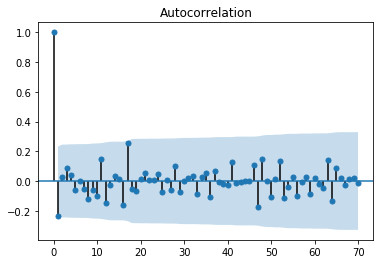

In [243]:
plot_acf(data_train.iloc[10000,3:])
pyplot.savefig("acf.png")

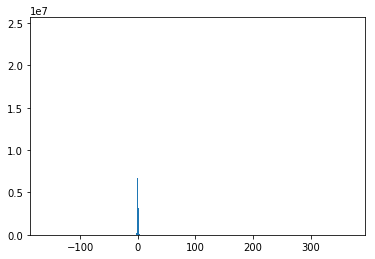

In [11]:
import matplotlib.pyplot as plt
fig = plt.hist( data_train.iloc[:,3:].values.reshape(-1,1),bins=1000)

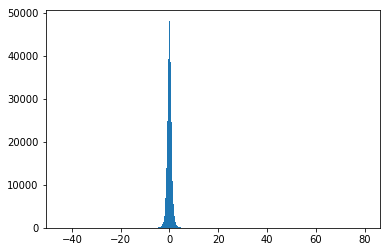

In [12]:
fig = plt.hist( output_train.iloc[:,1],bins=1000)

In [13]:
output_train.describe()

,ID,end_of_day_return
count,745327.000000,745327.000000
mean,372663.000000,0.000232
std,215157.516379,0.992946
min,0.000000,-44.524667
25%,186331.500000,-0.535876
50%,372663.000000,-0.005758
75%,558994.500000,0.528500
max,745326.000000,80.188626


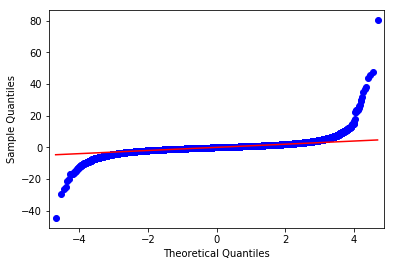

In [244]:
qqplot(output_train.iloc[:,1], line='s')
pyplot.savefig("qqplotReturn.png")

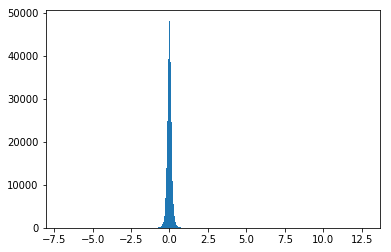

In [15]:
scale_output =  RobustScaler(quantile_range=(.01,.99)).fit_transform(output_train["end_of_day_return"].values.reshape(-1,1))
fig = plt.hist(scale_output,bins=1000)

In [16]:
scale_train_output = pd.DataFrame()
scale_train_output["ID"] = output_train["ID"]
scale_train_output["end_of_day_return"] = scale_output
scale_train_output.describe()

,ID,end_of_day_return
count,745327.000000,745327.000000
mean,372663.000000,0.000951
std,215157.516379,0.157642
min,0.000000,-7.067916
25%,186331.500000,-0.084163
50%,372663.000000,0.000000
75%,558994.500000,0.084820
max,745326.000000,12.731831


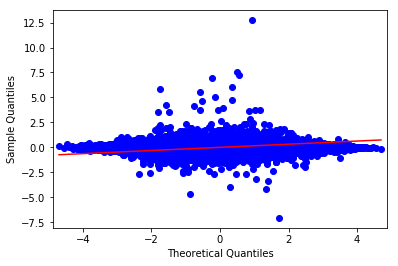

In [17]:
qqplot(scale_output,line='s')
pyplot.show()

In [18]:
equity_mean,equity_median,equity_std,equity_skew = getStat(data_train,groupName="eqt_code",dropName="date")

count    680.000000
mean      -0.000862
std        0.006353
min       -0.095697
25%       -0.003250
50%       -0.000628
75%        0.001468
max        0.032099
dtype: float64

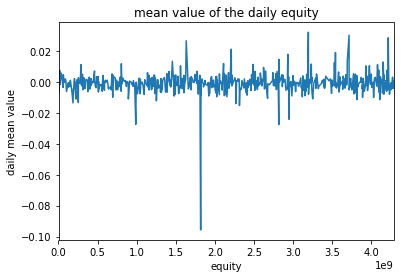

In [19]:
plotAndSave(equity_mean,title="mean value of the daily equity",xlabel="equity",ylabel="daily mean value",fileName="plotEquityMean.pdf")
equity_mean.describe()

count    680.000000
mean       0.463311
std        0.165968
min        0.180033
25%        0.360350
50%        0.436179
75%        0.526251
max        1.930447
dtype: float64

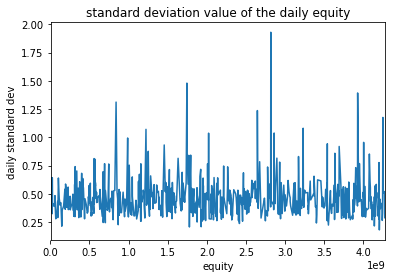

In [20]:
plotAndSave(equity_std,title="standard deviation value of the daily equity",xlabel="equity",ylabel="daily standard dev",fileName="plotEquityStd.pdf")
equity_std.describe()

count    680.000000
mean      -0.002312
std        0.003776
min       -0.028685
25%       -0.003992
50%       -0.002157
75%       -0.000169
max        0.022428
dtype: float64

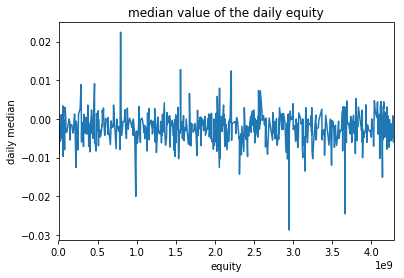

In [21]:
plotAndSave(equity_median,title="median value of the daily equity",xlabel="equity",ylabel="daily median",fileName="plotEquityMedian.pdf")
equity_median.describe()

count    680.000000
mean       1.861731
std        1.401303
min        0.271616
25%        0.864189
50%        1.449955
75%        2.377612
max       12.480709
dtype: float64

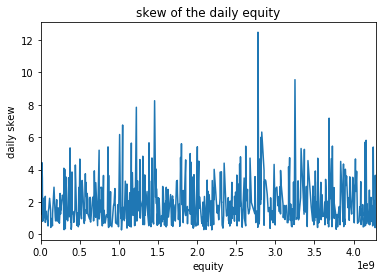

In [22]:
plotAndSave(equity_skew,title="skew of the daily equity",xlabel="equity",ylabel="daily skew",fileName="plotEquitySkew.pdf")
equity_skew.describe()

In [23]:
dataScale = scaleData(data_train,"RobustScaler")

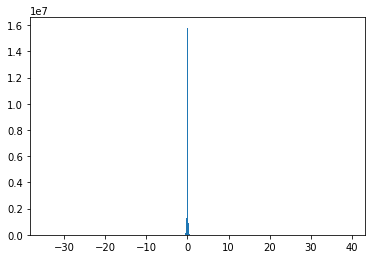

In [24]:
tmp = dataScale.iloc[:,3:].values.reshape(-1,1)
fig = plt.hist(tmp,bins=1000)

In [25]:
dataScale.describe()

,ID,eqt_code,date,09:30:00,09:35:00,09:40:00,09:45:00,09:50:00,09:55:00,10:00:00,...,14:35:00,14:40:00,14:45:00,14:50:00,14:55:00,15:00:00,15:05:00,15:10:00,15:15:00,15:20:00
count,745327.000000,7.453270e+05,7.453270e+05,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,...,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000,745327.000000
mean,372663.000000,2.096091e+09,2.130581e+09,-0.000184,0.000066,0.000046,0.000232,0.000188,0.000594,0.000894,...,0.000391,0.000263,0.000280,0.000204,0.000325,0.000159,0.000162,0.000647,0.000583,0.000711
std,215157.516379,1.253347e+09,1.216688e+09,0.066306,0.061797,0.065382,0.102709,0.121831,0.141772,0.156663,...,0.144764,0.091737,0.103648,0.095610,0.118398,0.133968,0.104358,0.134166,0.150679,0.149603
min,0.000000,3.667330e+06,1.003920e+05,-2.594426,-3.379257,-3.590523,-6.658874,-5.646200,-7.161657,-8.164946,...,-8.905830,-5.637155,-34.557901,-5.523097,-7.025453,-10.576710,-4.733144,-9.646408,-5.756274,-5.603336
25%,186331.500000,1.047929e+09,1.068003e+09,-0.022078,-0.028419,-0.032987,-0.053749,-0.064328,-0.076339,-0.086034,...,-0.072563,-0.046765,-0.045104,-0.039356,-0.060320,-0.070782,-0.053925,-0.068797,-0.079185,-0.079368
50%,372663.000000,2.002627e+09,2.208245e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,558994.500000,3.195928e+09,3.143717e+09,0.022078,0.028691,0.032992,0.054085,0.064372,0.076747,0.086884,...,0.072935,0.047397,0.045289,0.039338,0.060314,0.070688,0.054040,0.069202,0.079823,0.079709
max,745326.000000,4.283129e+09,4.292409e+09,6.237587,4.758201,9.040534,12.643287,16.779576,3.494350,4.636337,...,34.299482,4.766691,8.478978,39.472975,14.173483,6.377517,5.903032,10.870185,10.785536,9.259850


In [67]:
equity_scale_mean,equity_scale_median,equity_scale_std,equity_scale_skew = getStat(dataScale,groupName="eqt_code",dropName="date")

count    680.000000
mean       0.000394
std        0.001240
min       -0.018845
25%       -0.000029
50%        0.000414
75%        0.000848
max        0.007914
dtype: float64

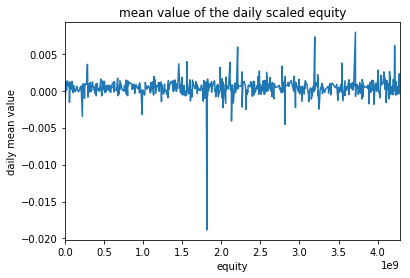

In [246]:
plotAndSave(equity_scale_mean,title="mean value of the daily scaled equity",xlabel="equity",ylabel="daily mean value",fileName="plotEquityScaleMean.png")
equity_scale_mean.describe()

count    680.000000
mean       0.032972
std        0.017569
min        0.020032
25%        0.027010
50%        0.029799
75%        0.033598
max        0.285208
dtype: float64

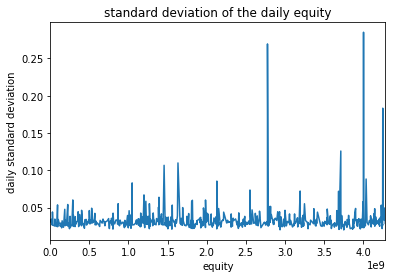

In [247]:
plotAndSave(equity_scale_std,title="standard deviation of the daily equity",xlabel="equity",ylabel="daily standard deviation",fileName="plotEquityScaleStd.png")
equity_scale_std.describe()

count    6.800000e+02
mean    -5.840450e-05
std      9.270646e-04
min     -6.775678e-03
25%     -5.021252e-04
50%      6.988971e-07
75%      4.378703e-04
max      5.686465e-03
dtype: float64

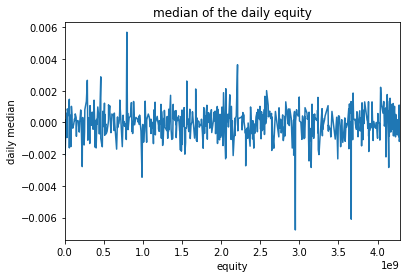

In [70]:
plotAndSave(equity_scale_median,title="median of the daily equity",xlabel="equity",ylabel="daily median",fileName="plotEquityScaleMedian.pdf")
equity_scale_median.describe()

count    680.000000
mean       1.861731
std        1.401303
min        0.271616
25%        0.864189
50%        1.449955
75%        2.377612
max       12.480709
dtype: float64

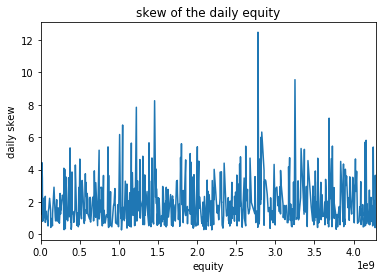

In [248]:
plotAndSave(equity_scale_skew,title="skew of the daily equity",xlabel="equity",ylabel="daily skew",fileName="plotEquityScaleSkew.png")
equity_scale_skew.describe()

In [72]:
stat = pd.DataFrame()
stat["equity mean"] = equity_scale_mean.describe()
stat["equity median"] = equity_scale_median.describe()
stat["equity std"] = equity_scale_std.describe()
stat["equity skew"] = equity_scale_skew.describe()
stat

,equity mean,equity median,equity std,equity skew
count,680.000000,6.800000e+02,680.000000,680.000000
mean,0.000394,-5.840450e-05,0.032972,1.861731
std,0.001240,9.270646e-04,0.017569,1.401303
min,-0.018845,-6.775678e-03,0.020032,0.271616
25%,-0.000029,-5.021252e-04,0.027010,0.864189
50%,0.000414,6.988971e-07,0.029799,1.449955
75%,0.000848,4.378703e-04,0.033598,2.377612
max,0.007914,5.686465e-03,0.285208,12.480709


In [32]:
equity_date_mean,equity_date_median,equity_date_std,equity_date_skew = getStat(data_train,groupName="date",dropName="eqt_code",axis=0)

count    680.000000
mean      -0.000862
std        0.006353
min       -0.095697
25%       -0.003250
50%       -0.000628
75%        0.001468
max        0.032099
dtype: float64

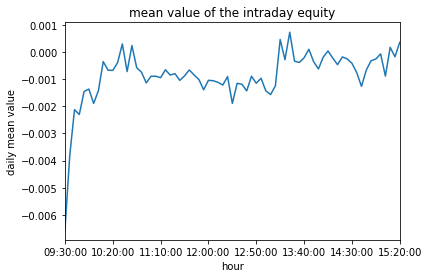

In [33]:
plotAndSave(equity_date_mean,title="mean value of the intraday equity",xlabel="hour",ylabel="daily mean value",fileName="plotIntradayMean.pdf")
equity_scale_mean.describe()

count    680.000000
mean      -0.000862
std        0.006353
min       -0.095697
25%       -0.003250
50%       -0.000628
75%        0.001468
max        0.032099
dtype: float64

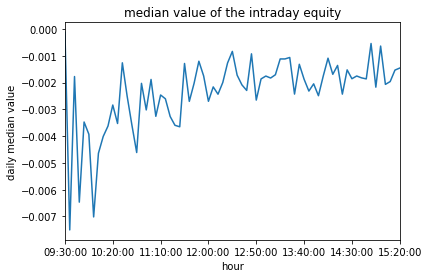

In [34]:
plotAndSave(equity_date_median,title="median value of the intraday equity",xlabel="hour",ylabel="daily median value",fileName="plotIntradayMedian.pdf")
equity_scale_mean.describe()

count    680.000000
mean      -0.000862
std        0.006353
min       -0.095697
25%       -0.003250
50%       -0.000628
75%        0.001468
max        0.032099
dtype: float64

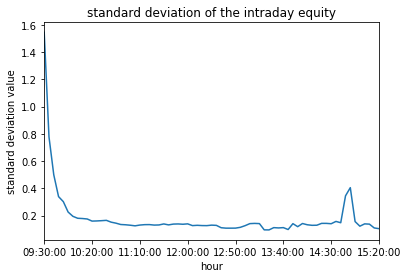

In [35]:
plotAndSave(equity_date_std,title="standard deviation of the intraday equity",xlabel="hour",ylabel="standard deviation value",fileName="plotIntradayStd.pdf")
equity_scale_mean.describe()

In [36]:
equity_scale_date_mean,equity_scale_date_median,equity_scale_date_std,equity_scale_date_skew = getStat(dataScale,groupName="date",dropName="eqt_code",axis=0)

count    71.000000
mean      0.000394
std       0.000265
min      -0.000186
25%       0.000187
50%       0.000366
75%       0.000602
max       0.000994
dtype: float64

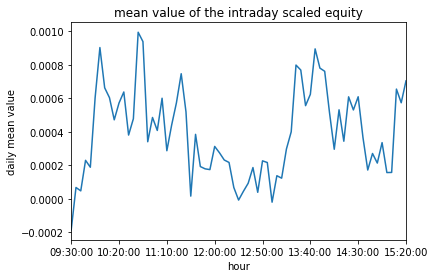

In [249]:
plotAndSave(equity_scale_date_mean,title="mean value of the intraday scaled equity",xlabel="hour",ylabel="daily mean value",fileName="plotIntradayScaleMean.png")
equity_scale_date_mean.describe()

count    71.000000
mean     -0.000011
std       0.000093
min      -0.000216
25%      -0.000077
50%      -0.000022
75%       0.000047
max       0.000229
dtype: float64

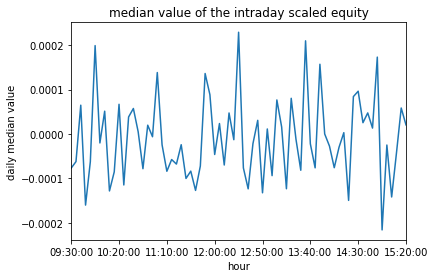

In [55]:
plotAndSave(equity_scale_date_median,title="median value of the intraday scaled equity",xlabel="hour",ylabel="daily median value",fileName="plotIntradayScaleMedian.pdf")
equity_scale_date_median.describe()

count    71.000000
mean      0.037428
std       0.009753
min       0.025223
25%       0.031301
50%       0.035450
75%       0.041279
max       0.075983
dtype: float64

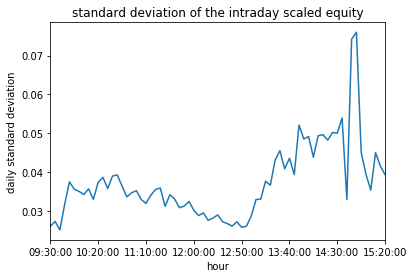

In [250]:
plotAndSave(equity_scale_date_std,title="standard deviation of the intraday scaled equity",xlabel="hour",ylabel="daily standard deviation",fileName="plotIntradayScaleStd.png")
equity_scale_date_std.describe()

count    71.000000
mean      1.367154
std       0.419735
min       0.816181
25%       1.135426
50%       1.329093
75%       1.506436
max       4.165111
dtype: float64

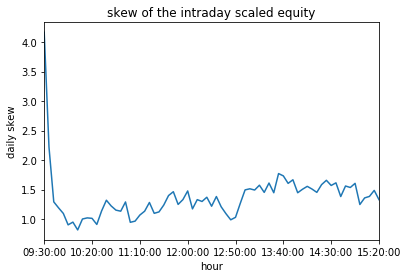

In [251]:
plotAndSave(equity_scale_date_skew,title="skew of the intraday scaled equity",xlabel="hour",ylabel="daily skew",fileName="plotIntradayScaleSkew.png")
equity_scale_date_skew.describe()

In [73]:
stat = pd.DataFrame()
stat["equity mean"] = equity_scale_date_mean.describe()
stat["equity median"] = equity_scale_date_median.describe()
stat["equity std"] = equity_scale_date_std.describe()
stat["equity skew"] = equity_scale_date_skew.describe()
stat

,equity mean,equity median,equity std,equity skew
count,71.000000,71.000000,71.000000,71.000000
mean,0.000394,-0.000011,0.037428,1.367154
std,0.000265,0.000093,0.009753,0.419735
min,-0.000186,-0.000216,0.025223,0.816181
25%,0.000187,-0.000077,0.031301,1.135426
50%,0.000366,-0.000022,0.035450,1.329093
75%,0.000602,0.000047,0.041279,1.506436
max,0.000994,0.000229,0.075983,4.165111


# Scatter plot

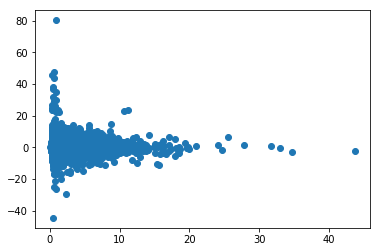

In [260]:
x = data_train.iloc[:,3:].std(axis=1)
y = output_train["end_of_day_return"].values
plt.scatter(x,y)
plt.savefig("meanScatter.png")

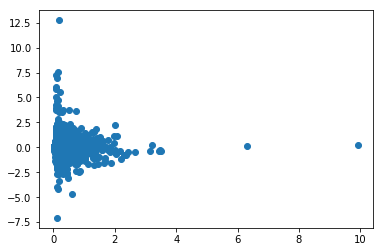

In [259]:
x = dataScale.iloc[:,3:].std(axis=1)
y = scale_output
plt.scatter(x,y)
plt.savefig("stdScatter.png")

# statistique data

In [43]:
stat_intraday = pd.DataFrame()
stat_intraday["intraday mean"] = equity_date_mean.describe()
stat_intraday["intraday median"] = equity_date_median.describe()
stat_intraday["intraday std"] = equity_date_std.describe()
stat_intraday["intraday skew"] = equity_date_skew.describe()
stat_intraday["intraday scaled mean"] = equity_scale_date_mean.describe()
stat_intraday["intraday scaled median"] = equity_scale_date_median.describe()
stat_intraday["intraday scaled std"] = equity_scale_date_std.describe()
stat_intraday["intraday scaled skew"] = equity_scale_date_skew.describe()

stat_intraday

,intraday mean,intraday median,intraday std,intraday skew,intraday scaled mean,intraday scaled median,intraday scaled std,intraday scaled skew
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,-0.000862,-0.002353,0.181888,1.367154,0.000394,-0.000011,0.037428,1.367154
std,0.000983,0.001359,0.192651,0.419735,0.000265,0.000093,0.009753,0.419735
min,-0.006554,-0.007504,0.095225,0.816181,-0.000186,-0.000216,0.025223,0.816181
25%,-0.001151,-0.002699,0.126713,1.135426,0.000187,-0.000077,0.031301,1.135426
50%,-0.000796,-0.002025,0.136783,1.329093,0.000366,-0.000022,0.035450,1.329093
75%,-0.000330,-0.001610,0.154242,1.506436,0.000602,0.000047,0.041279,1.506436
max,0.000729,-0.000117,1.544553,4.165111,0.000994,0.000229,0.075983,4.165111


# Train Test split

In [44]:
#drop not necessary data
dataTestScale = scaleData(data_test,"RobustScaler")
data_train_clean = dataScale.drop(['ID', 'eqt_code', 'date'], axis=1, inplace=False)
data_test_clean = dataTestScale.drop(['ID', 'eqt_code', 'date'], axis=1, inplace=False)
output_logistic= pd.DataFrame()
output_logistic["ID"] = output_train["ID"]
output_logistic["end_of_day_return"] = scale_train_output["end_of_day_return"].apply(lambda row : 1 if row > 0 else 0)
output_log = output_logistic["end_of_day_return"].values
X_train,X_test,y_train,y_test = train_test_split(data_train_clean,output_log,test_size=.3)

# Helper

In [45]:
def evaluateModel(model,train_set=X_train,test_set=X_test,output_train=y_train,output_test=y_test,checkCFM=False):
    print("we train")
    model.fit(train_set,output_train)
    print("compute the score")
    print("train score : ",logistic.score(X_train,y_train))
    print("test score : ",logistic.score(X_test,y_test))
    if checkCFM:
        print('CFM metric : Train error =', round(CFM_metrics(pd.DataFrame(data=y_pred_proba), pd.DataFrame(data=output_train)), 4), '%')
        print('Test error =', round(CFM_metrics(pd.DataFrame(data=y_pred_test_proba), pd.DataFrame(data=output_test)), 4), '%')

def computeProba(model,trainSet = data_train_clean,trainOutput=output_log,testSet=data_test_clean):
    model.fit(trainSet,trainOutput)
    print("score on full training set : ",model.score(trainSet,trainOutput))
    return model.predict_proba(testSet)


def sendPredictionToCfmFormat(prediction, test = data_test, fileName = 'predictions'):
    output = pd.DataFrame()
    output["ID"] = test["ID"]
    output["end_of_day_return"] = prediction
    output.to_csv(fileName+'.csv', sep=',', index=False)
    print("prediction send to"+fileName+'.csv')


# Logistic regression

In [46]:
logistic = LogisticRegression(solver='sag')
evaluateModel(logistic)
y_pred_logistic = computeProba(logistic)

we train
compute the score
train score :  0.5211240339793916
test score :  0.5194745951457743
score on full training set :  0.5205741909255938


In [47]:
sendPredictionToCfmFormat(y_pred_logistic[:,1],fileName='predictionLogistic')

prediction send topredictionLogistic.csv


# Logistic regression with Cross validation

In [48]:
logistic = LogisticRegressionCV(solver='sag',Cs=10,cv=5,verbose=1)
evaluateModel(logistic)
y_pred_logisticCs = computeProba(logistic)

we train


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 6 seconds
convergence after 12 epochs took 5 seconds
convergence after 20 epochs took 8 seconds
convergence after 23 epochs took 9 seconds
convergence after 18 epochs took 8 seconds
convergence after 11 epochs took 4 seconds
convergence after 5 epochs took 2 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 1 seconds
convergence after 15 epochs took 6 seconds
convergence after 13 epochs took 5 seconds
convergence after 19 epochs took 8 seconds
convergence after 23 epochs took 9 seconds
convergence after 18 epochs took 7 seconds
convergence after 11 epochs took 4 seconds
convergence after 5 epochs took 2 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 0 seconds
convergence after 15 epochs took 6 seconds
convergence after 12 epochs took 4 seconds
convergence after 19 epochs took 8 seconds
convergence after 2

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.7min finished


compute the score
train score :  0.5211240339793916
test score :  0.5195103734810979


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 15 epochs took 9 seconds
convergence after 12 epochs took 7 seconds
convergence after 16 epochs took 9 seconds
convergence after 13 epochs took 7 seconds
convergence after 11 epochs took 7 seconds
convergence after 8 epochs took 4 seconds
convergence after 3 epochs took 2 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 1 seconds
convergence after 15 epochs took 8 seconds
convergence after 12 epochs took 7 seconds
convergence after 16 epochs took 9 seconds
convergence after 13 epochs took 8 seconds
convergence after 11 epochs took 6 seconds
convergence after 7 epochs took 4 seconds
convergence after 3 epochs took 2 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 1 seconds
convergence after 14 epochs took 8 seconds
convergence after 13 epochs took 7 seconds
convergence after 17 epochs took 10 seconds
convergence after 13

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.0min finished


score on full training set :  0.5205795576974939


In [49]:
logistic.score(data_train[data_train.columns[3:]],output_log)

0.5149189550358433

In [50]:
print(logistic.C_)
sendPredictionToCfmFormat(y_pred_logisticCs[:,1],fileName='predictionLogisticCV')

[21.5443469]
prediction send topredictionLogisticCV.csv


In [75]:
logistic5 = LogisticRegressionCV(solver='sag',Cs=5,cv=5,verbose=1)
evaluateModel(logistic5)
y_pred_logisticCs5 = computeProba(logistic5)
print(logistic5.score(data_train[data_train.columns[3:]],output_log))
print(logistic5.C_)

we train


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 15 epochs took 14 seconds
convergence after 24 epochs took 21 seconds
convergence after 24 epochs took 23 seconds
convergence after 8 epochs took 8 seconds
convergence after 2 epochs took 1 seconds
convergence after 15 epochs took 14 seconds
convergence after 24 epochs took 23 seconds
convergence after 23 epochs took 22 seconds
convergence after 8 epochs took 8 seconds
convergence after 2 epochs took 2 seconds
convergence after 15 epochs took 15 seconds
convergence after 23 epochs took 22 seconds
convergence after 23 epochs took 21 seconds
convergence after 8 epochs took 8 seconds
convergence after 2 epochs took 2 seconds
convergence after 14 epochs took 13 seconds
convergence after 24 epochs took 23 seconds
convergence after 24 epochs took 23 seconds
convergence after 8 epochs took 8 seconds
convergence after 2 epochs took 2 seconds
convergence after 16 epochs took 15 seconds
convergence after 25 epochs took 24 seconds
convergence after 25 epochs took 24 seconds
conv

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.8min finished


compute the score
train score :  0.5207311089303238
test score :  0.520225940187568


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 16 epochs took 22 seconds
convergence after 18 epochs took 26 seconds
convergence after 13 epochs took 15 seconds
convergence after 6 epochs took 9 seconds
convergence after 2 epochs took 3 seconds
convergence after 14 epochs took 20 seconds
convergence after 18 epochs took 25 seconds
convergence after 13 epochs took 12 seconds
convergence after 6 epochs took 5 seconds
convergence after 2 epochs took 2 seconds
convergence after 14 epochs took 20 seconds
convergence after 18 epochs took 25 seconds
convergence after 13 epochs took 18 seconds
convergence after 6 epochs took 9 seconds
convergence after 2 epochs took 3 seconds
convergence after 13 epochs took 19 seconds
convergence after 18 epochs took 25 seconds
convergence after 13 epochs took 18 seconds
convergence after 6 epochs took 9 seconds
convergence after 2 epochs took 2 seconds
convergence after 15 epochs took 21 seconds
convergence after 18 epochs took 25 seconds
convergence after 13 epochs took 19 seconds
conv

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.1min finished


score on full training set :  0.5205916329342691
0.5149135882639432
[100.]


In [76]:
logistic20 = LogisticRegressionCV(solver='sag',Cs=20,cv=5,verbose=1)
evaluateModel(logistic20)
y_pred_logisticCs20 = computeProba(logistic20)
print(logistic20.score(data_train[data_train.columns[3:]],output_log))
print(logistic20.C_)

we train


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 15 epochs took 15 seconds
convergence after 8 epochs took 7 seconds
convergence after 11 epochs took 11 seconds
convergence after 13 epochs took 11 seconds
convergence after 17 epochs took 16 seconds
convergence after 20 epochs took 19 seconds
convergence after 20 epochs took 19 seconds
convergence after 18 epochs took 17 seconds
convergence after 15 epochs took 14 seconds
convergence after 12 epochs took 12 seconds
convergence after 8 epochs took 7 seconds
convergence after 6 epochs took 6 seconds
convergence after 3 epochs took 3 seconds
convergence after 2 epochs took 2 seconds
convergence after 2 epochs took 2 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 2 seconds
convergence after 2 epochs took 2 seconds
convergence after 2 epochs took 2 seconds
convergence after 2 epochs took 2 seconds
convergence after 14 epochs took 14 seconds
convergence after 9 epochs took 8 seconds
convergence after 11 epochs took 11 seconds
convergence 

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 17.9min finished


compute the score
train score :  0.5207311089303238
test score :  0.520225940187568


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 17 epochs took 24 seconds
convergence after 8 epochs took 12 seconds
convergence after 11 epochs took 11 seconds
convergence after 14 epochs took 11 seconds
convergence after 15 epochs took 10 seconds
convergence after 13 epochs took 19 seconds
convergence after 12 epochs took 17 seconds
convergence after 11 epochs took 15 seconds
convergence after 9 epochs took 9 seconds
convergence after 8 epochs took 5 seconds
convergence after 6 epochs took 4 seconds
convergence after 4 epochs took 2 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 2 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 2 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 1 seconds
convergence after 15 epochs took 10 seconds
convergence after 8 epochs took 10 seconds
convergence after 12 epochs took 16 seconds
convergence af

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 15.8min finished


score on full training set :  0.5205527238379932
0.5149524973602191
[0.23357215]


In [98]:
Cs = [.001, .01, 1, 5, 10, 20,50,100, 1000]
score_train = []
score_test = []
for C in Cs:
    lr = LogisticRegression(C=C,solver='sag',verbose=1)
    lr.fit(X_train,y_train)
    score_train.append(lr.score(X_train,y_train))
    score_test.append(lr.score(X_test,y_test))

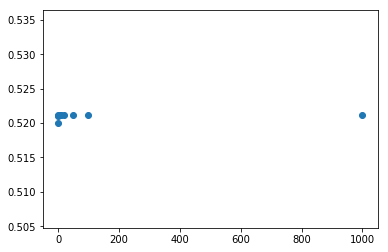

In [252]:
pyplot.scatter(Cs,score_train)
pyplot.savefig("Cl2.png")

In [253]:
score_train

[0.5200123435966634,
 0.5209611138370952,
 0.521125950686948,
 0.5211317008096172,
 0.5211336175171737,
 0.5211202005642787,
 0.521125950686948,
 0.521125950686948,
 0.5211278673945045]

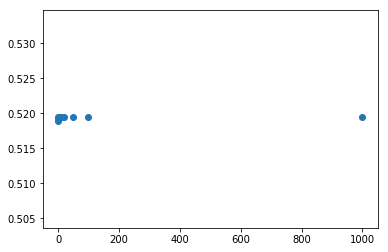

In [254]:
pyplot.scatter(Cs,score_test)
pyplot.savefig("Cl2Test.png")

In [106]:
Cs = [.001, .01, 1, 5, 10, 20,50,100, 1000]
score_train_l1 = []
score_test_l1 = []
for C in Cs:
    lr = LogisticRegression(C=C,solver='saga',penalty='l1',verbose=1)
    lr.fit(X_train,y_train)
    score_train_l1.append(lr.score(X_train,y_train))
    score_test_l1.append(lr.score(X_test,y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 6 epochs took 11 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 34 epochs took 57 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 27 epochs took 49 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 27 epochs took 49 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 26 epochs took 49 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 27 epochs took 49 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 27 epochs took 51 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 26 epochs took 50 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 26 epochs took 51 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.5s finished


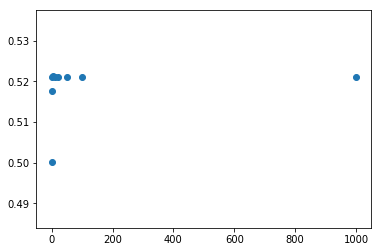

In [255]:
pyplot.scatter(Cs,score_train_l1)
pyplot.savefig("Cl1.png")

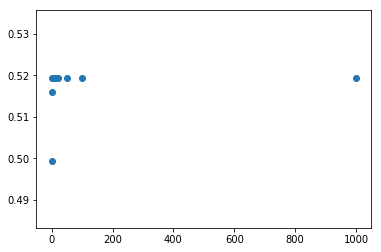

In [256]:
pyplot.scatter(Cs,score_test_l1)
pyplot.savefig("Cl1Test.png")

In [113]:
score_train_l1

[0.5002165879538764,
 0.5175455409715407,
 0.5211547013002944,
 0.5211853686211972,
 0.5211547013002944,
 0.5211221172718351,
 0.5211317008096172,
 0.5211240339793916,
 0.5211240339793916]

# SVM

## Linear

In [114]:
svc = LinearSVC(tol=1.e-3,verbose=1)
evaluateModel(svc)

we train
[LibLinear]

C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


compute the score
train score :  0.5207311089303238
test score :  0.520225940187568


In [101]:
y_pred_SVC = svc.predict(data_test_clean)

In [150]:
index= 0
for C in Cs:
    svc = LinearSVC(tol=1.e-3,verbose=1,C=C)
    svc.fit(X_train, y_train)
    these_scores.append(svc.score(X_train, y_train))
    these_test_scores.append(svc.score(X_test, y_test))
    print(these_scores[index])
    print(these_test_scores[index])
    index = index + 1

[LibLinear]0.5184578230119027
0.5181776304902974
[LibLinear]

C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5210549517949897
0.518052406316665
[LibLinear]

C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5205950226938175
0.5187769176069661
[LibLinear]

C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5205988561089303
0.5187411392716426
[LibLinear]

C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5208250276005888
0.5184728017567163
[LibLinear]

C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.521058865922473
0.5193985661832119
[LibLinear]

C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5212773705839058
0.5195864024436603
[LibLinear]

C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5215322926889107
0.5198368507909248
[LibLinear]0.521072282875368
0.5200783545543585


C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [179]:
data_embedded = TSNE(n_components=2).fit_transform(data_train)

KeyboardInterrupt: 

# Neural network

In [183]:
Y_train = np_utils.to_categorical(y_train,2 )
Y_test = np_utils.to_categorical(y_test,2 )
batch_size=500
n_epoch=20

In [184]:
def createNN(layer1=1000,layer2=100, activation1='relu', activation2='tanh'):
    model = Sequential()
    model.add(Dense(layer1,input_dim=X_train.shape[1], name='fc1',kernel_initializer=glorot_normal()))
    model.add(Dropout(.2))
    model.add(Activation(activation1))
    model.add(Dense(layer2, input_dim=layer1, name='fc2',kernel_initializer=glorot_normal()))
    model.add(Dropout(.2))
    model.add(Activation(activation2))
    model.add(Dense(2,name='fc3',activation='softmax'))
    adam = Adamax()
    model.compile(loss="categorical_crossentropy",optimizer=adam,metrics=["binary_accuracy"])
    return model

In [230]:
model1 = createNN(layer1=1000,layer2=100,activation1='relu',activation2='tanh')
model2 = createNN(layer1=2000,layer2=100,activation1='relu',activation2='tanh')
model3 = createNN(layer1=3000,layer2=100,activation1='relu',activation2='tanh')
model4 = createNN(layer1=100,layer2=10,activation1='relu',activation2='tanh')
model5 = createNN(layer1=5000,layer2=10,activation1='relu',activation2='tanh')
model6 = createNN(layer1=100,layer2=100,activation1='relu',activation2='tanh')

In [190]:
model1.fit(X_train,Y_train,epochs=n_epoch,batch_size=batch_size,verbose=1)
model2.fit(X_train,Y_train,epochs=n_epoch,batch_size=batch_size,verbose=1)
model3.fit(X_train,Y_train,epochs=n_epoch,batch_size=batch_size,verbose=1)
model4.fit(X_train,Y_train,epochs=n_epoch,batch_size=batch_size,verbose=1)
model5.fit(X_train,Y_train,epochs=n_epoch,batch_size=batch_size,verbose=1)


Epoch 1/20
521728/521728 [==============================] - 20s 38us/step - loss: 0.6932 - binary_accuracy: 0.5131 0s - loss: 0.6933 - binary_accu
Epoch 2/20
521728/521728 [==============================] - 18s 35us/step - loss: 0.6921 - binary_accuracy: 0.5196
Epoch 3/20
521728/521728 [==============================] - 17s 33us/step - loss: 0.6917 - binary_accuracy: 0.5230 7s - loss: 0.691 - ETA: 5s - loss: 0.6916 - binary_accuracy - ETA: 2s - l
Epoch 4/20
521728/521728 [==============================] - 17s 32us/step - loss: 0.6911 - binary_accuracy: 0.5265 2s - los
Epoch 5/20
521728/521728 [==============================] - 15s 29us/step - loss: 0.6902 - binary_accuracy: 0.5310
Epoch 6/20
521728/521728 [==============================] - 15s 29us/step - loss: 0.6894 - binary_accuracy: 0.5338
Epoch 7/20
521728/521728 [==============================] - 14s 26us/step - loss: 0.6885 - binary_accuracy: 0.5371
Epoch 8/20
521728/521728 [==============================] - 13s 25us/step - loss

521728/521728 [==============================] - 8s 15us/step - loss: 0.6912 - binary_accuracy: 0.5260
Epoch 9/20
521728/521728 [==============================] - 9s 16us/step - loss: 0.6911 - binary_accuracy: 0.5266
Epoch 10/20
521728/521728 [==============================] - 9s 16us/step - loss: 0.6909 - binary_accuracy: 0.5266
Epoch 11/20
521728/521728 [==============================] - 9s 17us/step - loss: 0.6907 - binary_accuracy: 0.5284
Epoch 12/20
521728/521728 [==============================] - 8s 15us/step - loss: 0.6905 - binary_accuracy: 0.5302
Epoch 13/20
521728/521728 [==============================] - 9s 17us/step - loss: 0.6904 - binary_accuracy: 0.5296
Epoch 14/20
521728/521728 [==============================] - 10s 19us/step - loss: 0.6903 - binary_accuracy: 0.5306
Epoch 15/20
521728/521728 [==============================] - 9s 16us/step - loss: 0.6900 - binary_accuracy: 0.5317
Epoch 16/20
521728/521728 [==============================] - 10s 19us/step - loss: 0.6898 - 

In [231]:
model6.fit(X_train,Y_train,epochs=n_epoch,batch_size=batch_size,verbose=1)

Epoch 1/20
521728/521728 [==============================] - 12s 24us/step - loss: 0.6935 - binary_accuracy: 0.5089
Epoch 2/20
521728/521728 [==============================] - 9s 18us/step - loss: 0.6926 - binary_accuracy: 0.5159
Epoch 3/20
521728/521728 [==============================] - 10s 18us/step - loss: 0.6922 - binary_accuracy: 0.5193
Epoch 4/20
521728/521728 [==============================] - 9s 18us/step - loss: 0.6920 - binary_accuracy: 0.5196
Epoch 5/20
521728/521728 [==============================] - 9s 18us/step - loss: 0.6919 - binary_accuracy: 0.5220
Epoch 6/20
521728/521728 [==============================] - 9s 18us/step - loss: 0.6916 - binary_accuracy: 0.5237
Epoch 7/20
521728/521728 [==============================] - 9s 18us/step - loss: 0.6914 - binary_accuracy: 0.5242
Epoch 8/20
521728/521728 [==============================] - 9s 18us/step - loss: 0.6911 - binary_accuracy: 0.5265
Epoch 9/20
521728/521728 [==============================] - 9s 18us/step - loss: 0.691

In [232]:
train =[]
train.append(model1.evaluate(X_train,Y_train,verbose=1)[1])
train.append(model2.evaluate(X_train,Y_train,verbose=1)[1])
train.append(model3.evaluate(X_train,Y_train,verbose=1)[1])
train.append(model4.evaluate(X_train,Y_train,verbose=1)[1])
train.append(model5.evaluate(X_train,Y_train,verbose=1)[1])
train.append(model6.evaluate(X_train,Y_train,verbose=1)[1])

521728/521728 [==============================] - 28s 53us/step


In [233]:
test =[]
test.append(model1.evaluate(X_test,Y_test,verbose=1)[1])
test.append(model2.evaluate(X_test,Y_test,verbose=1)[1])
test.append(model3.evaluate(X_test,Y_test,verbose=1)[1])
test.append(model4.evaluate(X_test,Y_test,verbose=1)[1])
test.append(model5.evaluate(X_test,Y_test,verbose=1)[1])
test.append(model6.evaluate(X_test,Y_test,verbose=1)[1])

223599/223599 [==============================] - 13s 58us/step


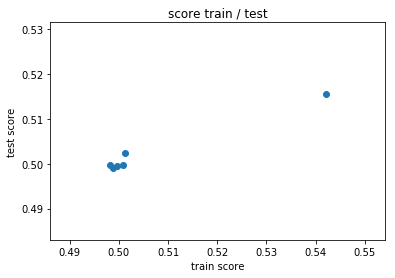

In [257]:
plt.scatter(train,test)
plt.xlabel("train score")
plt.ylabel("test score")
plt.title("score train / test")
plt.savefig("scoreTrainTest.png")

In [258]:
print(train)
print(test)
model5.summary()

[0.49815996074582924, 0.49875222338076547, 0.499654992639843, 0.5013091112610403, 0.500877852060844, 0.5420966480618253]
[0.4997428432149956, 0.49904069338600454, 0.4995550069548138, 0.5023725508630058, 0.4998143998859092, 0.5154763661737727]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 5000)              360000    
_________________________________________________________________
dropout_51 (Dropout)         (None, 5000)              0         
_________________________________________________________________
activation_51 (Activation)   (None, 5000)              0         
_________________________________________________________________
fc2 (Dense)                  (None, 10)                50010     
_________________________________________________________________
dropout_52 (Dropout)         (None, 10)                0         
_______________________________

In [176]:
y_pred = model.predict_proba(data_train_clean)
CFM_metrics(pd.DataFrame(output_train["end_of_day_return"].values),pd.DataFrame(y_pred[:,1]))

0.5331351205578223

In [174]:
test_pred =  model.predict_proba(data_test_clean)
sendPredictionToCfmFormat(test_pred[:,1],fileName='NN')

prediction send toNN.csv


# Decision tree

In [121]:
arbre = GradientBoostingClassifier(loss='exponential',verbose=1)

In [122]:
arbre.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           0.9999           19.63m
         2           0.9998           18.93m
         3           0.9998           15.93m
         4           0.9997           14.41m
         5           0.9996           13.33m
         6           0.9996           12.93m
         7           0.9995           13.44m
         8           0.9995           13.88m
         9           0.9995           14.16m
        10           0.9994           14.28m
        20           0.9991           13.94m
        30           0.9988           12.64m
        40           0.9986           10.46m
        50           0.9984            8.69m
        60           0.9982            6.96m
        70           0.9980            5.22m
        80           0.9978            3.49m
        90           0.9977            1.75m
       100           0.9975            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False)

In [125]:
proba = arbre.predict_proba(X_train)
proba

array([[0.5396409 , 0.4603591 ],
       [0.50541641, 0.49458359],
       [0.44310129, 0.55689871],
       ...,
       [0.47717554, 0.52282446],
       [0.50924938, 0.49075062],
       [0.51149184, 0.48850816]])

In [130]:
print(arbre.score(X_train,y_train))
print(arbre.score(X_test,y_test))

0.5325571945534838
0.5176409554604449
